In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
import shutil

2024-05-06 14:04:03.052385: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 14:04:03.052715: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 14:04:03.055372: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 14:04:03.086142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 14:04:03.722826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
try:
    shutil.rmtree("coco-2017")
except:
    pass
fo.config.dataset_zoo_dir = ""

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=["laptop"],
    max_samples=10000,
    shuffle=True,
)

 100% |██████|    1.9Gb/1.9Gb [24.0s elapsed, 0s remaining, 76.3Mb/s]      
Extracting annotations to 'coco-2017/raw/instances_train2017.json'
Only found 3524 (<10000) samples matching your requirements
 100% |████████████████| 3524/3524 [3.8m elapsed, 0s remaining, 16.3 images/s]      
Writing annotations for 3524 downloaded samples to 'coco-2017/train/labels.json'
Dataset info written to 'coco-2017/info.json'
Loading existing dataset 'coco-2017-train-10000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


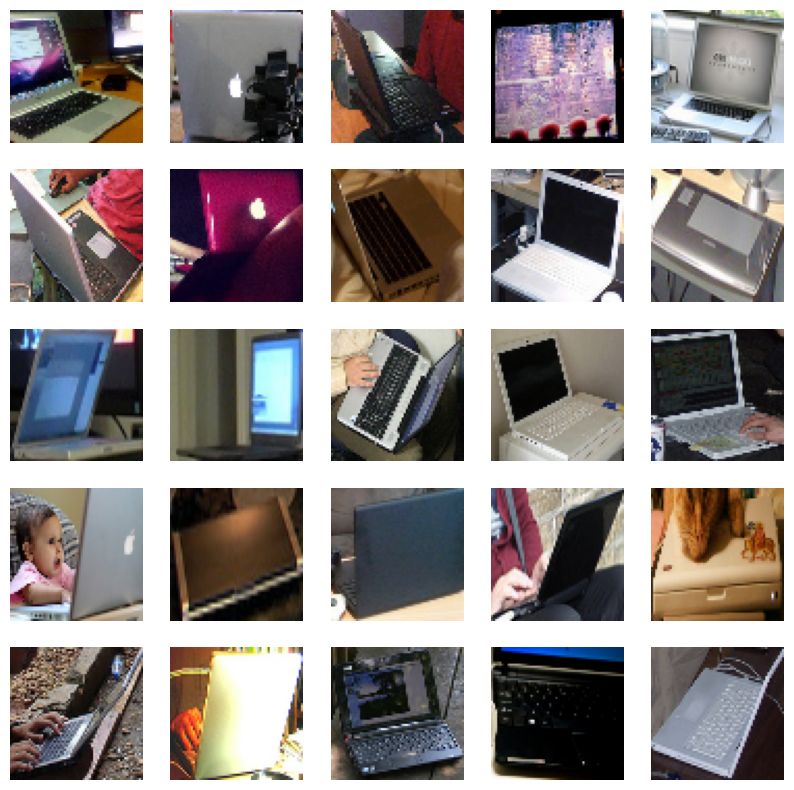

Number of images: 4970


In [3]:
def extract_and_preprocess_images(dataset):
    images = []
    for sample in dataset.select_fields("ground_truth"):
        # Assurez-vous que le fichier image peut être chargé
        if not os.path.exists(sample.filepath):
            continue
        image = cv2.imread(sample.filepath)
        if image is None:
            continue
        
        # Accéder aux détections
        detections = sample["ground_truth"].detections
        for detection in detections:
            # Vérifiez si la détection est un laptop
            if detection.label == "laptop":
                # Extraire les coordonnées de la boîte englobante
                bbox = detection.bounding_box
                xmin = int(bbox[0] * image.shape[1])
                ymin = int(bbox[1] * image.shape[0])
                xmax = int((bbox[0] + bbox[2]) * image.shape[1])
                ymax = int((bbox[1] + bbox[3]) * image.shape[0])

                # Rogner et redimensionner l'image
                cropped = image[ymin:ymax, xmin:xmax]
                resized = cv2.resize(cropped, (64, 64))

                # Convertir BGR en RGB et normaliser
                rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
                normalized = (rgb - 127.5) / 127.5
                images.append(normalized)
                # save image in test folder
                # create folder if not exists
                #if not os.path.exists('test'):
                #    os.makedirs('test')
                #cv2.imwrite('test/'+str(len(images))+'.jpg', cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

    return np.array(images)

# Process images
images = extract_and_preprocess_images(dataset)

# Visualize processed images
plt.figure(figsize=(10, 10))
for i in range(min(25, len(images))):
    plt.subplot(5, 5, i + 1)
    plt.imshow((images[i] + 1) / 2)
    plt.axis("off")
plt.show()

print("Number of images:", len(images))


In [4]:
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(512 * 4 * 4, input_dim=z_dim, activation="relu"),
        layers.Reshape((4, 4, 512)),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model


In [5]:
def build_discriminator(image_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=image_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [6]:
@tf.function
def train_step(generator, discriminator, real_imgs, z_dim, batch_size):
    noise = tf.random.normal([batch_size, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Générer des images
        fake_imgs = generator(noise, training=True)

        # Discriminateur décisions
        real_output = discriminator(real_imgs, training=True)
        fake_output = discriminator(fake_imgs, training=True)

        # Pertes
        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
        d_loss = (d_loss_real + d_loss_fake) / 2
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

    # Gradients et optimisation
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

def train_gan(generator, discriminator, images, z_dim, epochs=2000, batch_size=64):
    for epoch in range(epochs):
        for i in range(0, images.shape[0], batch_size):
            img_batch = images[i:i+batch_size]
            g_loss, d_loss = train_step(generator, discriminator, img_batch, z_dim, batch_size)

            if i % 10 == 0:
                print(f"Epoch: {epoch}, Batch: {i}, D Loss: {d_loss}, G Loss: {g_loss}")

# Préparez les optimiseurs
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialiser les modèles
z_dim = 100
generator = build_generator(z_dim)
discriminator = build_discriminator((64, 64, 3))

# Lancer l'entraînement
train_gan(generator, discriminator, images, z_dim)

/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-05-06 14:08:56.437155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_A

Epoch: 0, Batch: 0, D Loss: 0.7106492519378662, G Loss: 0.7512751817703247
Epoch: 0, Batch: 320, D Loss: 0.6523942947387695, G Loss: 0.6753489971160889
Epoch: 0, Batch: 640, D Loss: 0.6189727187156677, G Loss: 0.7046481370925903
Epoch: 0, Batch: 960, D Loss: 0.5456465482711792, G Loss: 0.753633439540863
Epoch: 0, Batch: 1280, D Loss: 0.4950992465019226, G Loss: 0.8842095136642456
Epoch: 0, Batch: 1600, D Loss: 0.4037821292877197, G Loss: 1.0803766250610352
Epoch: 0, Batch: 1920, D Loss: 0.32601964473724365, G Loss: 1.346498966217041
Epoch: 0, Batch: 2240, D Loss: 0.23816551268100739, G Loss: 1.625605583190918
Epoch: 0, Batch: 2560, D Loss: 0.19486206769943237, G Loss: 1.775270938873291
Epoch: 0, Batch: 2880, D Loss: 0.19821733236312866, G Loss: 1.7762846946716309
Epoch: 0, Batch: 3200, D Loss: 0.21340075135231018, G Loss: 1.633857250213623
Epoch: 0, Batch: 3520, D Loss: 0.2644544839859009, G Loss: 1.6517479419708252
Epoch: 0, Batch: 3840, D Loss: 0.272990882396698, G Loss: 1.9101457595

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


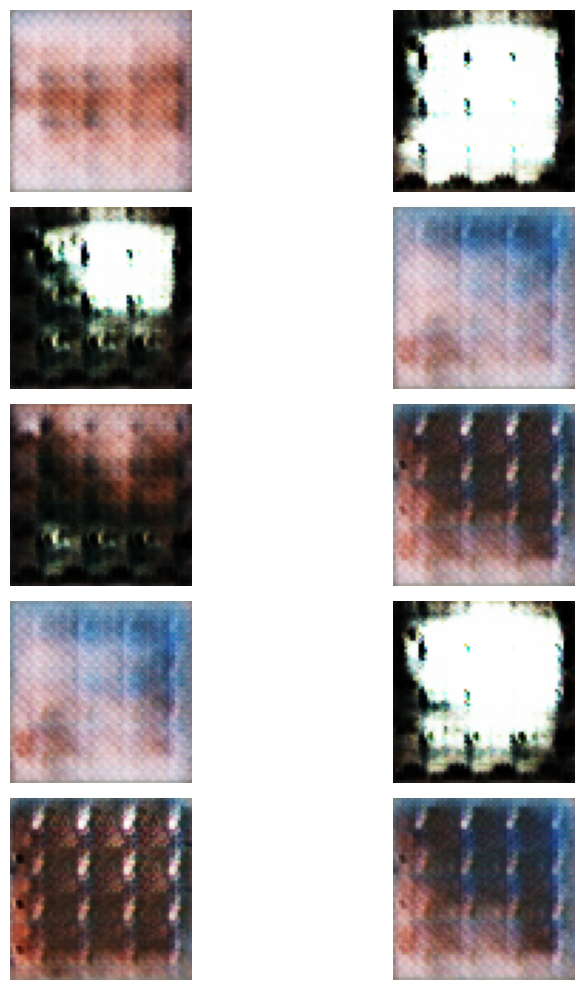

In [7]:
def generate_images(generator, z_dim, n_images=10):
    z = np.random.normal(0, 1, (n_images, z_dim))
    fake_images = generator.predict(z)
    fake_images = (fake_images + 1) / 2  # Normalisation pour affichage

    # Convertir les images pour sauvegarde : de [0, 1] à [0, 255]
    fake_images = (fake_images * 255).astype(np.uint8)

    if not os.path.exists('test'):
        os.makedirs('test')
    for i in range(n_images):
        # Aucun besoin de convertir de RGB à BGR pour l'affichage, mais nécessaire pour l'enregistrement avec cv2
        cv2.imwrite('test/'+str(i)+'.jpg', cv2.cvtColor(fake_images[i], cv2.COLOR_RGB2BGR))

    # Reconvertir pour affichage avec Matplotlib si nécessaire
    fake_images = fake_images / 255.0
    return fake_images

# Génération d'images
generated_images = generate_images(generator, z_dim, 10)

# Affichage des images générées
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde des modèles
generator.save("generator.h5")
discriminator.save("discriminator.h5")